# **HW4: Unsupervised Learning**

---



In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = data.data
true_lbl = data.target

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

"""
This code creates a TF-IDF vectorizer that transforms a list of text documents into numerical feature vectors.
It limits the vocabulary to the 2000 most frequent terms and excludes common English stop words.
The vectorizer then fits to the input documents and transforms them into a sparse matrix 'X' where each row
represents a document and each column represents a term weighted by its TF-IDF score.
"""

vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(documents)

In [18]:
import seaborn as sns

"""
Ploting a 2D scatter plot of data points colored by cluster labels with a colorbar and axis labels.
"""

def plot_2d(data_2d, labels, title):
    plt.figure(figsize=(10, 7))

    scatter = plt.scatter(
        data_2d[:, 0], data_2d[:, 1],
        c=labels,
        cmap='tab20',
        s=10,
        alpha=0.6
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label('Label')

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()


In [64]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X.toarray())

# **K-Means**

In [65]:
from sklearn.cluster import KMeans

"""
Performed PCA to reduce data to 20 components, then applied KMeans clustering with 20 clusters on the reduced data.
"""
pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X_normalized)

kmeans = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# **DBSCAN**

In [66]:
"""
Calculated cosine distance matrix from data X and applied DBSCAN clustering using this precomputed distance matrix.
"""

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

dist_matrix = cosine_distances(X)
dbscan = DBSCAN(metric='precomputed', eps=0.3, min_samples=3)
dbscan_labels = dbscan.fit_predict(dist_matrix)


In [9]:
X.shape

(18846, 1000)

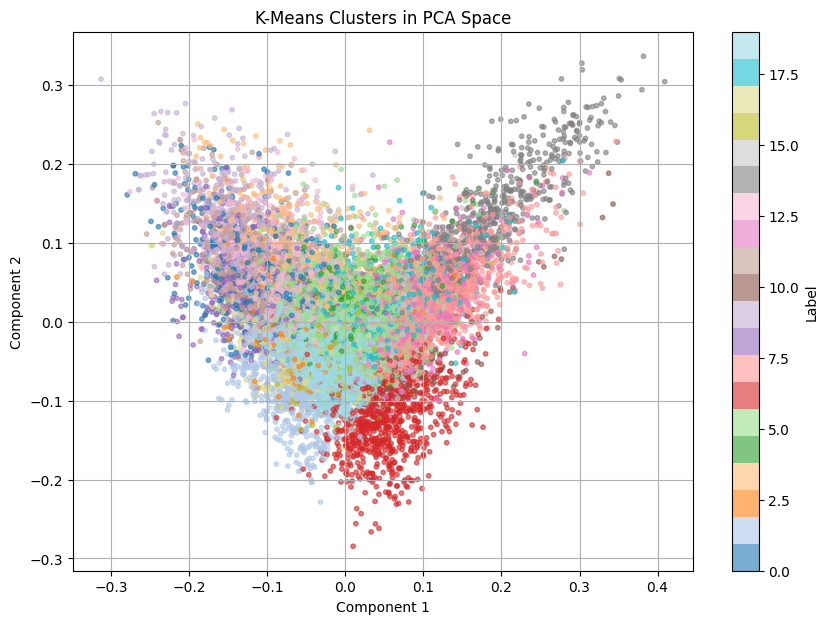

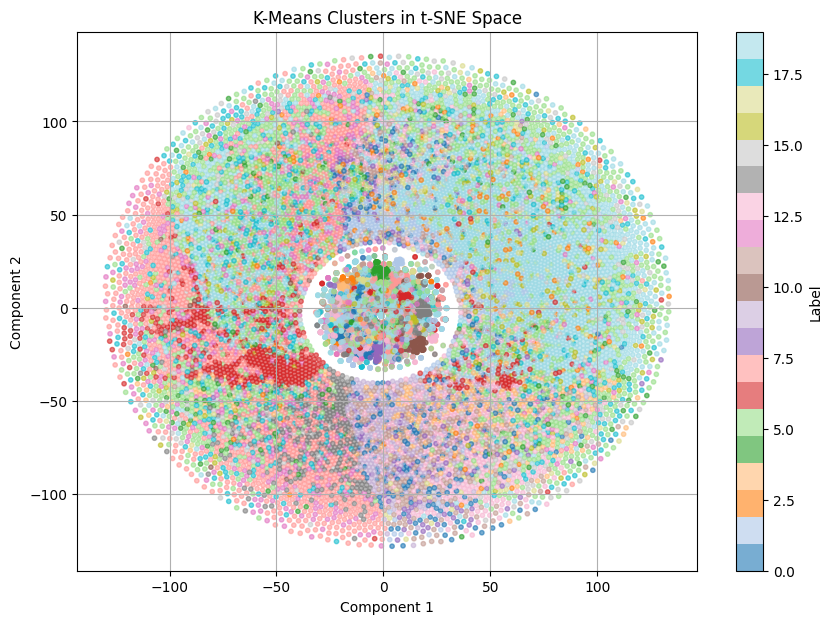

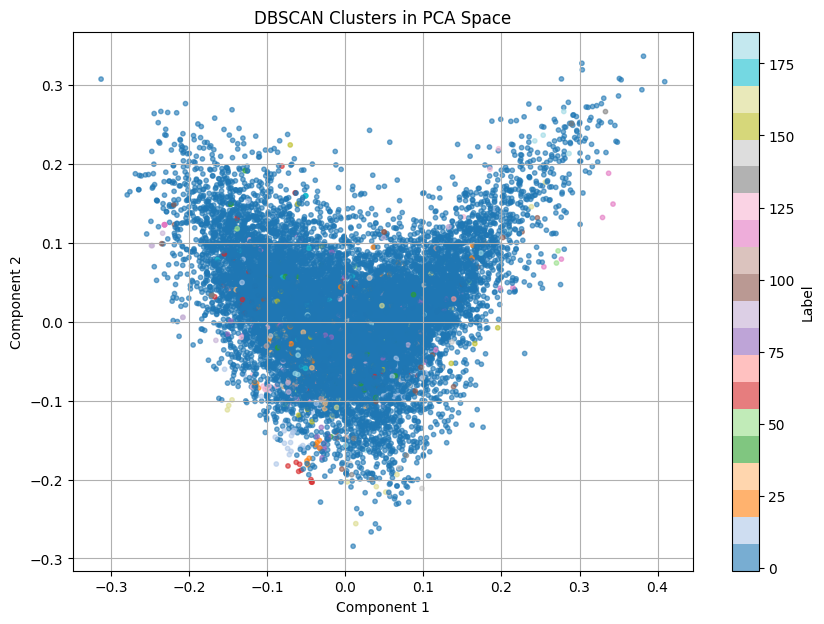

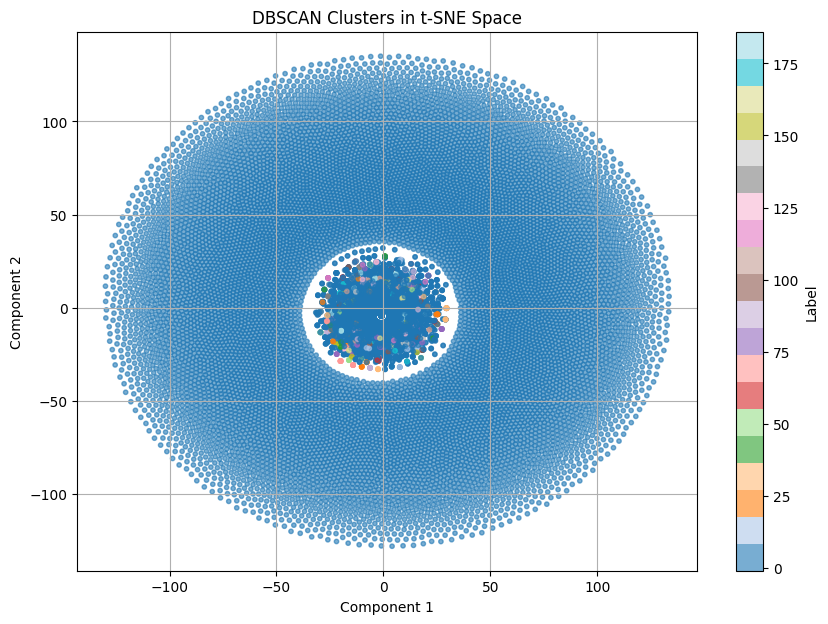

In [54]:
"""
Reduced data to 2D using PCA and t-SNE, then plotted K-Means and DBSCAN cluster assignments in both reduced spaces.
"""

pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X.toarray())

tsne = TSNE(n_components=2, perplexity=50, max_iter=1000, random_state=42)
X_tsne_2d = tsne.fit_transform(X.toarray())

plot_2d(X_pca_2d, kmeans_labels, "K-Means Clusters in PCA Space")
plot_2d(X_tsne_2d, kmeans_labels, "K-Means Clusters in t-SNE Space")
plot_2d(X_pca_2d, dbscan_labels, "DBSCAN Clusters in PCA Space")
plot_2d(X_tsne_2d, dbscan_labels, "DBSCAN Clusters in t-SNE Space")


In [8]:
"""
Comparing with the reference class labels using clustering metrics such as B-Cubed precision and recall.
"""
def pr_bcubed(y_test, y_pred, is_precision):
    n = y_test.shape[0]
    I = np.eye(n)
    y_test = y_test[:, np.newaxis]
    y_pred = y_pred[:, np.newaxis]
    yt_matrix = (y_test == y_test.T) - I
    yp_matrix = (y_pred == y_pred.T) - I
    cor_matrix = (yt_matrix == yp_matrix) - I
    y = yp_matrix if is_precision else yt_matrix
    nom = (cor_matrix * y).sum(axis=1)
    denom = y.sum(axis=1)
    res = nom / denom
    res = res[~np.isnan(res)].mean()
    if np.isnan(res):
        res = 1
    return res

def precision_bcubed(y_test, y_pred):
    return pr_bcubed(y_test, y_pred, True)

def recall_bcubed(y_test, y_pred):
    return pr_bcubed(y_test, y_pred, False)

In [67]:
import pandas as pd

results = []
sample_size = X.shape[0]
indices = np.random.choice(len(true_lbl), sample_size, replace=False)
sample_true = true_lbl[indices]

for name, labels in [('K-Means', kmeans_labels), ('DBSCAN', dbscan_labels)]:
    sample_labels = labels[indices]
    precision = precision_bcubed(sample_true, sample_labels)
    recall = recall_bcubed(sample_true, sample_labels)
    results.append({
        'Method': name,
        'B-Cubed Precision': f"{precision:.2f}",
        'B-Cubed Recall': f"{recall:.2f}"
    })

df_results = pd.DataFrame(results)

In [68]:
df_results

,Method,B-Cubed Precision,B-Cubed Recall
0,K-Means,0.21,0.22
1,DBSCAN,0.08,0.91


# **Identified top 10 words with the highest average TF-IDF scores for each cluster.**

In [43]:
feature_names = vectorizer.get_feature_names_out()

X_dense = X.toarray()

data = []
for cluster_id in range(20):
    cluster_indices = np.where(kmeans_labels == cluster_id)[0]

    cluster_tfidf = X_dense[cluster_indices]

    avg_tfidf_scores = np.mean(cluster_tfidf, axis=0)

    top_10_indices = np.argsort(avg_tfidf_scores)[::-1][:10]

    top_10_words = feature_names[top_10_indices]
    top_10_scores = avg_tfidf_scores[top_10_indices]

    for i, (word, score) in enumerate(zip(top_10_words, top_10_scores)):
        data.append([cluster_id, i + 1, word, score])

df_top_words = pd.DataFrame(data, columns=['Cluster', 'Rank', 'Word', 'TF-IDF Score'])

tmp = df_top_words.pivot(index='Cluster', columns='Rank', values=['Word', 'TF-IDF Score'])

tmp.columns = [f'{col[0]}_{col[1]}' for col in tmp.columns]

tmp = tmp.reset_index()

tmp

,Cluster,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,...,TF-IDF Score_1,TF-IDF Score_2,TF-IDF Score_3,TF-IDF Score_4,TF-IDF Score_5,TF-IDF Score_6,TF-IDF Score_7,TF-IDF Score_8,TF-IDF Score_9,TF-IDF Score_10
0,0,file,window,program,files,use,image,using,problem,display,...,0.073626,0.052504,0.051444,0.044806,0.044796,0.032611,0.030433,0.02799,0.027433,0.026799
1,1,god,jesus,christ,believe,bible,faith,sin,people,lord,...,0.309763,0.082606,0.049943,0.047142,0.045542,0.045038,0.043467,0.034981,0.034109,0.03406
2,2,did,say,time,does,church,christian,evidence,believe,think,...,0.037385,0.03346,0.032346,0.030616,0.029144,0.026273,0.025843,0.025203,0.024376,0.023817
3,3,just,like,ve,use,good,space,got,know,time,...,0.079398,0.074631,0.02823,0.022832,0.022301,0.021698,0.020034,0.019506,0.018274,0.018127
4,4,edu,soon,cs,university,mail,email,internet,ftp,cc,...,0.251086,0.036004,0.033855,0.03357,0.02381,0.021415,0.020603,0.01979,0.019395,0.018572
5,5,card,video,monitor,bus,cards,drivers,vga,driver,isa,...,0.211963,0.089931,0.069393,0.065233,0.050715,0.04285,0.042374,0.035653,0.032849,0.031512
6,6,team,year,season,players,games,good,play,hockey,teams,...,0.121267,0.101373,0.056742,0.056432,0.05004,0.046366,0.039164,0.037586,0.037113,0.035678
7,7,com,list,dave,mail,bob,ibm,address,phone,internet,...,0.261991,0.029868,0.026875,0.026738,0.024634,0.023962,0.021403,0.020925,0.020005,0.019529
8,8,key,chip,clipper,encryption,keys,escrow,government,algorithm,phone,...,0.175714,0.1129,0.098932,0.092645,0.07778,0.059345,0.054149,0.047509,0.042596,0.041395
9,9,windows,dos,ms,file,os,files,run,running,program,...,0.255361,0.119398,0.044561,0.044375,0.043705,0.03542,0.035022,0.033197,0.03313,0.031021


# **Named clusters based on their content**
#### Cluster 0
- **Name**: Autos
- **Top 10 Words**: car, bike, engine, cars, speed, ride, road, rear, turn, miles

#### Cluster 1
- **Name**: Religion
- **Top 10 Words**: god, jesus, bible, christian, faith, christ, church, sin, hell, lord

#### Cluster 2
- **Name**: Cryptography
- **Top 10 Words**: key, chip, clipper, encryption, keys, security, government, privacy, phone, escrow

#### Cluster 3
- **Name**: Windows OS
- **Top 10 Words**: windows, dos, file, files, drivers, driver, program, disk, nt, pc

#### Cluster 4
- **Name**: For Sale
- **Top 10 Words**: sale, offer, shipping, price, new, condition, email, interested, sell, asking

#### Cluster 5
- **Name**: Hardware
- **Top 10 Words**: card, video, monitor, cards, vga, mac, bus, diamond, color, ram

#### Cluster 6
- **Name**: Space
- **Top 10 Words**: space, nasa, orbit, launch, moon, earth, mission, satellite, solar, lunar

#### Cluster 7
- **Name**: Storage
- **Top 10 Words**: drive, scsi, hard, ide, controller, disk, drives, cd, floppy, mb

#### Cluster 8
- **Name**: U.S. Politics
- **Top 10 Words**: president, clinton, tax, health, jobs, money, economic, care, national, budget

#### Cluster 9
- **Name**: Hockey
- **Top 10 Words**: team, game, play, season, games, players, league, score, hockey, win

#### Cluster 10
- **Name**: Graphics
- **Top 10 Words**: graphics, image, display, color, screen, file, software, bit, format, program

#### Cluster 11
- **Name**: Mideast Conflict
- **Top 10 Words**: israel, palestine, arab, peace, war, jewish, israeli, conflict, army, land

#### Cluster 12
- **Name**: Medical
- **Top 10 Words**: medical, doctor, disease, health, treatment, cancer, pain, patient, drug, care

#### Cluster 13
- **Name**: Gun Rights
- **Top 10 Words**: gun, guns, law, rights, control, weapons, people, government, crime, carry

#### Cluster 14
- **Name**: General Talk
- **Top 10 Words**: post, article, write, people, think, good, time, day, question, like

#### Cluster 15
- **Name**: Education
- **Top 10 Words**: university, student, course, school, education, professor, class, degree, campus, learn

#### Cluster 16
- **Name**: Email
- **Top 10 Words**: mail, email, address, send, list, message, info, contact, subject, reply

#### Cluster 17
- **Name**: Civil Rights
- **Top 10 Words**: people, government, right, think, gun, don, just, like, fbi, law

#### Cluster 18
- **Name**: Baseball
- **Top 10 Words**: game, games, espn, baseball, hockey, play, team, night, goal, season

#### Cluster 19
- **Name**: Casual Talk
- **Top 10 Words**: don, think, know, just, like, want, people, really, use, good

**Which dimensionality reduction technique produced more meaningful visual separation? Why?**

t-SNE provided better visual separation than PCA. This is because PCA uses a simple linear method that struggles with the complex, overlapping topics in the 20 Newsgroups dataset.

**Which clustering algorithm matched the original topics better?**

K-Means matched the original topics better.K-Means in t-SNE space better matched the original topics, inferred from its clear, varied cluster assignments compared to DBSCAN’s tendency to form a large cluster with noise.

**What challenges did you face when clustering textual data?**

High dimensionality, noise, distance metrics, sparsity, and interpretability complicate clustering textual data.

**Could you identify any meaningful topics based on the clusters alone?**

Meaningful topics cannot be reliably identified from clusters alone due to the lack of contextual labels or content.